## Image Classification

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Check if GPU is available

GPUs = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Avilable: ", len(GPUs))
for GPU in GPUs:
    tf.config.experimental.set_memory_growth(GPU, True)

Num GPUs Avilable:  1


In [3]:
data_dir = 'DATA/TRAIN_SET'
test_dir = 'DATA/TEST_SET'
img_size = 256
batch_size = 32

In [4]:
# Train dataset preprocessing (deleting corrupted photos)

img_num = 0
corrupted_img_num = 0
train_set_path = data_dir
train_set_dirs = os.listdir(train_set_path)
for dir in train_set_dirs:
    dir_path = os.path.join(train_set_path, dir)
    files = os.listdir(dir_path)
    img_num += len(files)
    for file in files:
        file_path = os.path.join(dir_path, file)
        try:
            open_file = open(file_path, 'rb')
            is_JFIF = tf.compat.as_bytes('JFIF') in open_file.peek(10)
        finally:
            open_file.close()
        if not is_JFIF:
            corrupted_img_num += 1
            os.remove(file_path)
            img_num -= 1
print("Deleted {} images".format(corrupted_img_num))
print("Total number of images: {}".format(img_num))

Deleted 0 images
Total number of images: 6018


In [5]:
checkpoint_filepath = 'CHECKPOINT\MODEL_6'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_filepath,
    save_weights_only = True,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True)

In [6]:
# training dataset augmentation
train_datagen = ImageDataGenerator(
    validation_split = 0.2,
    rotation_range = 15,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.15,
    zoom_range = 0.25,
    horizontal_flip = True,
    vertical_flip = True,
    fill_mode = "nearest")

validation_datagen = ImageDataGenerator(
    validation_split = 0.2)

In [7]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    subset = "training",
    seed = 0,
    target_size = (img_size, img_size),
    batch_size = batch_size
)

Found 4818 images belonging to 6 classes.


In [8]:
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    subset = "validation",
    seed = 0,
    target_size = (img_size, img_size),
    batch_size = batch_size
)

Found 1200 images belonging to 6 classes.


In [9]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size = (img_size, img_size),
    batch_size = batch_size,
    color_mode = 'rgb',
    shuffle = False
)

Found 300 files belonging to 6 classes.


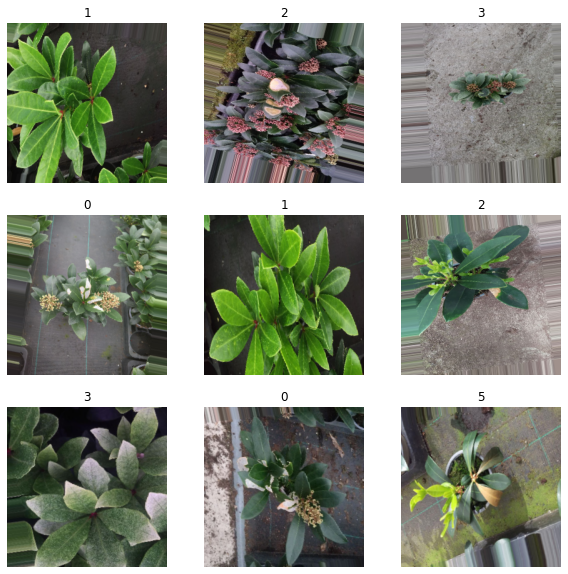

In [10]:
# Sample images from the training dataset

plt.figure(figsize = (10, 10))
example_img = train_generator
images = example_img[0][0]
labels = example_img[0][1]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))
    plt.title(int(np.argmax(labels[i])))
    plt.axis("off")

In [11]:
# CNN model

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(
    scale = (1./255), 
    input_shape = (img_size, img_size, 3)))

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(
    256, 
    kernel_regularizer = tf.keras.regularizers.l1(0.0005), 
    activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(
    512, 
    kernel_regularizer = tf.keras.regularizers.l1(0.0005), 
    activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(6, activation = 'softmax'))

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0

In [13]:
training_steps = img_num * 0.8 // batch_size
validtion_steps = img_num * 0.2 // batch_size

print("Training steps number: ", training_steps)
print("Validation steps number: ", validtion_steps)

Training steps number:  150.0
Validation steps number:  37.0


In [14]:
history = model.fit(
    train_generator,
    epochs = 60,
    steps_per_epoch = training_steps,
    validation_data = validation_generator,
    validation_steps = validtion_steps,
    callbacks = [model_checkpoint_callback])

Epoch 1/60
150/150 [==============================] - 211s 1s/step - loss: 32.0803 - accuracy: 0.4342 - val_loss: 20.9601 - val_accuracy: 0.1799
Epoch 2/60
150/150 [==============================] - 184s 1s/step - loss: 18.5047 - accuracy: 0.5019 - val_loss: 17.9269 - val_accuracy: 0.3311
Epoch 3/60
150/150 [==============================] - 177s 1s/step - loss: 16.9203 - accuracy: 0.5516 - val_loss: 18.2218 - val_accuracy: 0.1715
Epoch 4/60
150/150 [==============================] - 187s 1s/step - loss: 16.0842 - accuracy: 0.6101 - val_loss: 16.0319 - val_accuracy: 0.3910
Epoch 5/60
150/150 [==============================] - 169s 1s/step - loss: 15.2809 - accuracy: 0.6515 - val_loss: 15.3593 - val_accuracy: 0.3505
Epoch 6/60
150/150 [==============================] - 164s 1s/step - loss: 14.1579 - accuracy: 0.6987 - val_loss: 13.0272 - val_accuracy: 0.7356
Epoch 7/60
150/150 [==============================] - 160s 1s/step - loss: 13.6016 - accuracy: 0.7246 - val_loss: 14.7483 - val_ac

In [15]:
model.load_weights(checkpoint_filepath)

In [16]:
model.evaluate(train_generator, steps = training_steps)

150/150 [==============================] - 143s 948ms/step - loss: 10.7407 - accuracy: 0.8092


[10.740745544433594, 0.809166669845581]

In [17]:
model.evaluate(validation_generator, steps = validtion_steps)

37/37 [==============================] - 14s 363ms/step - loss: 10.7801 - accuracy: 0.8066


[10.780102729797363, 0.806587815284729]

In [18]:
# Model predictions

predictions = model.predict(test_set)

10/10 [==============================] - 2s 148ms/step


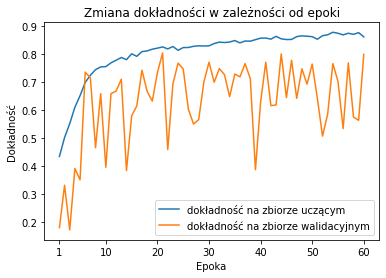

In [28]:
# Accuracy change plot during training

epochs = [i + 1 for i in range(60)]

plt.plot()

plt.plot(epochs, history.history['accuracy'])
plt.plot(epochs, history.history['val_accuracy'])
plt.xticks([1, 10, 20, 30, 40, 50, 60])
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.title('Zmiana dokładności w zależności od epoki')
plt.legend(['dokładność na zbiorze uczącym', 'dokładność na zbiorze walidacyjnym'])

plt.show()

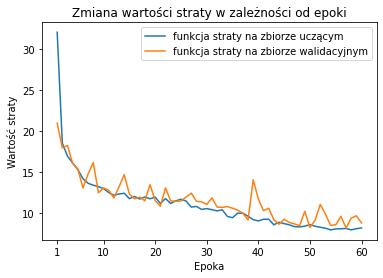

In [29]:
# Loss function change plot during training

plt.plot()

plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xticks([1, 10, 20, 30, 40, 50, 60])
plt.xlabel('Epoka')
plt.ylabel('Wartość straty')
plt.title('Zmiana wartości straty w zależności od epoki')
plt.legend(['funkcja straty na zbiorze uczącym', 'funkcja straty na zbiorze walidacyjnym'])

plt.show()

In [ ]:
model.save('MODELS/CNN_MODEL_6')

In [22]:
# test dataset labels

dirs = os.listdir(data_dir)

ANS = []

for label, class_name in enumerate(dirs):
    ANS.extend([label] * 50)

In [23]:
# labels predicted by the model

test_pred = []

for pred in predictions:
    test_pred.append(np.argmax(pred))

In [24]:
# Prediction accuracy

res_list = list(zip(test_pred, ANS))
counter = 0
for res in res_list:
    if res[0] == res[1]:
        counter += 1
acc = counter / len(res_list)
print("Prediction accuracy: ", acc)

Prediction accuracy:  0.8766666666666667


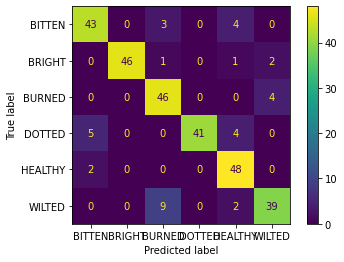

In [25]:
confusionMatrix = confusion_matrix(ANS, test_pred)
confusionMatrixDisplay = ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = dirs)

confusionMatrixDisplay.plot()

In [26]:
# Confusion matrix adjustment

def plot_confusion_matrix(
        cm,
        target_names,
        title='Confusion matrix',
        cmap=None,
        normalize=True):

    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Prawdziwe etykiety')
    plt.xlabel('Przewidziane etykiety\nDokładność={:0.4f}; Błąd={:0.4f}'.format(accuracy, misclass))
    plt.show()

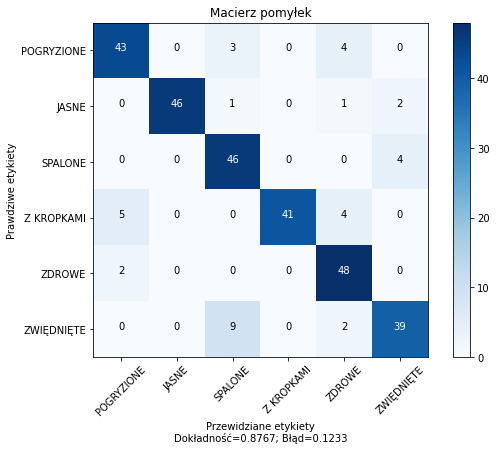

In [27]:
labels = ['POGRYZIONE', 'JASNE', 'SPALONE', 'Z KROPKAMI', 'ZDROWE', 'ZWIĘDNIĘTE']
plot_confusion_matrix(confusionMatrix, labels, title = 'Macierz pomyłek', normalize = False)